In [1]:
import os
import sys

# Set Spark environment variables
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Initialize findspark
import findspark
findspark.init()

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("nyc-jobs-analysis") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .getOrCreate()

## Data Loading and Initial Exploration

In [2]:
# Read the dataset
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True, inferSchema=True)

# Convert numeric columns
df = df.withColumn("# Of Positions", col("# Of Positions").cast("integer")) \
       .withColumn("Salary Range From", col("Salary Range From").cast("double")) \
       .withColumn("Salary Range To", col("Salary Range To").cast("double")) \
       .withColumn("Posting Date", to_timestamp(col("Posting Date"), "yyyy-MM-dd'T'HH:mm:ss.SSS"))

# Display basic statistics
print("Dataset Overview:")
print(f"Total number of records: {df.count()}")
print(f"Number of columns: {len(df.columns)}")
print("\nColumn Types:")
df.printSchema()

# Show sample data
df.show(5, truncate=False)

Dataset Overview:
Total number of records: 2946
Number of columns: 28

Column Types:
root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply

## Key Analysis Questions

### 1. Highest Salary Job Posting per Agency

In [3]:
# Group by Agency and Business Title to find highest salary jobs
highest_salary_jobs = df.groupBy("Agency", "Business Title") \
                       .agg(
                           max("Salary Range To").alias("Highest Salary"),
                           first("Posting Date").alias("Posting Date"),
                           first("Job Description").alias("Job Description")
                       ) \
                       .orderBy(col("Highest Salary").desc())

print("Top 10 Highest Paying Jobs by Agency:")
highest_salary_jobs.show(10, truncate=False)

Top 10 Highest Paying Jobs by Agency:
+------------------------------+------------------------------------------------+--------------+-------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2. Average Salary per Agency (Last 2 Years)

In [4]:
# Calculate average salaries for the last 2 years
# First, ensure Posting Date is in proper date format
df = df.withColumn("Posting Date", to_timestamp(col("Posting Date"), "yyyy-MM-dd'T'HH:mm:ss.SSS"))

# Get the date two years ago from the most recent posting
max_date = df.select(max("Posting Date")).collect()[0][0]
two_years_ago = df.select(add_months(lit(max_date), -24)).collect()[0][0]  # Subtract 24 months from max date

# Filter and calculate averages
recent_salaries = df.filter(col("Posting Date") >= two_years_ago) \
                   .groupBy("Agency") \
                   .agg(
                       avg("Salary Range From").alias("Avg Salary From"),
                       avg("Salary Range To").alias("Avg Salary To"),
                       count(lit(1)).alias("Number of Postings")
                   ) \
                   .orderBy(col("Avg Salary To").desc())

print("Average Salary per Agency (Last 2 Years):")
print(f"Analysis period: {two_years_ago} to {max_date}")
recent_salaries.show(truncate=False)

Average Salary per Agency (Last 2 Years):
Analysis period: 2017-12-17 to 2019-12-17 00:00:00
+------------------------------+------------------+------------------+------------------+
|Agency                        |Avg Salary From   |Avg Salary To     |Number of Postings|
+------------------------------+------------------+------------------+------------------+
|CONFLICTS OF INTEREST BOARD   |100000.0          |170000.0          |2                 |
|FINANCIAL INFO SVCS AGENCY    |78496.3           |109492.7          |20                |
|DEPT OF INFO TECH & TELECOMM  |60167.362799999995|106584.09119999997|50                |
|CONSUMER AFFAIRS              |69194.85714285714 |105025.71428571429|7                 |
|BUSINESS INTEGRITY COMMISSION |90000.0           |100000.0          |2                 |
|MAYORS OFFICE OF CONTRACT SVCS|75357.14285714286 |99357.14285714286 |28                |
|NYC HOUSING AUTHORITY         |57634.41625       |96694.24437500001 |64                |
|HUMAN 

### 3. Highest Paid Skills Analysis

In [5]:
# Function to extract skills and their associated salaries
def extract_skills(row):
    skills = str(row['Preferred Skills']).lower().split(',')
    return [(skill.strip(), float(row['Salary Range To'])) for skill in skills]

# Process skills and calculate average salaries
skills_rdd = df.select('Preferred Skills', 'Salary Range To').rdd
skills_salary = skills_rdd.flatMap(extract_skills) \
                         .map(lambda x: (x[0], (x[1], 1))) \
                         .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
                         .map(lambda x: (x[0], x[1][0] / x[1][1], x[1][1])) \
                         .filter(lambda x: x[2] >= 5) \
                         .sortBy(lambda x: x[1], ascending=False)

# Display results
print("Top 20 Highest Paid Skills:")
print("Skill | Average Salary | Number of Appearances")
print("-" * 50)
for skill, avg_salary, count in skills_salary.take(20):
    print(f"{skill:30} | ${avg_salary:,.2f} | {count}")

Top 20 Highest Paid Skills:
Skill | Average Salary | Number of Appearances
--------------------------------------------------
commercial                     | $219,745.67 | 6
capacity to organize and analyze data | $183,933.00 | 5
construction and construction management | $183,933.00 | 5
track and staff multiple contracts for engineering design | $183,933.00 | 5
public utility                 | $183,323.80 | 5
inspectors                     | $171,913.00 | 6
other agencies                 | $171,913.00 | 6
state and federal environmental requirements for water | $169,478.20 | 5
vendors                        | $156,639.71 | 7
mysql                          | $156,275.33 | 6
mongodb                        | $156,275.33 | 6
architecture                   | $151,900.67 | 6
azure                          | $150,000.00 | 6
contractors                    | $149,722.50 | 8
consultants                    | $149,722.50 | 8
project management             | $146,997.60 | 5
at least 18 months of 

### 4. Number of Job Postings per Category (Top 10)

In [6]:
# Count job postings per category
category_counts = df.groupBy("Job Category") \
                   .count() \
                   .orderBy(col("count").desc()) \
                   .limit(10)

print("Top 10 Job Categories by Number of Postings:")
category_counts.show(truncate=False)

Top 10 Job Categories by Number of Postings:
+-----------------------------------------+-----+
|Job Category                             |count|
+-----------------------------------------+-----+
|Engineering, Architecture, & Planning    |504  |
|Technology, Data & Innovation            |313  |
|Legal Affairs                            |226  |
|Public Safety, Inspections, & Enforcement|182  |
|Building Operations & Maintenance        |181  |
|Finance, Accounting, & Procurement       |169  |
|Administration & Human Resources         |134  |
|Constituent Services & Community Programs|129  |
|Health                                   |125  |
|Policy, Research & Analysis              |124  |
+-----------------------------------------+-----+



## Data Visualization

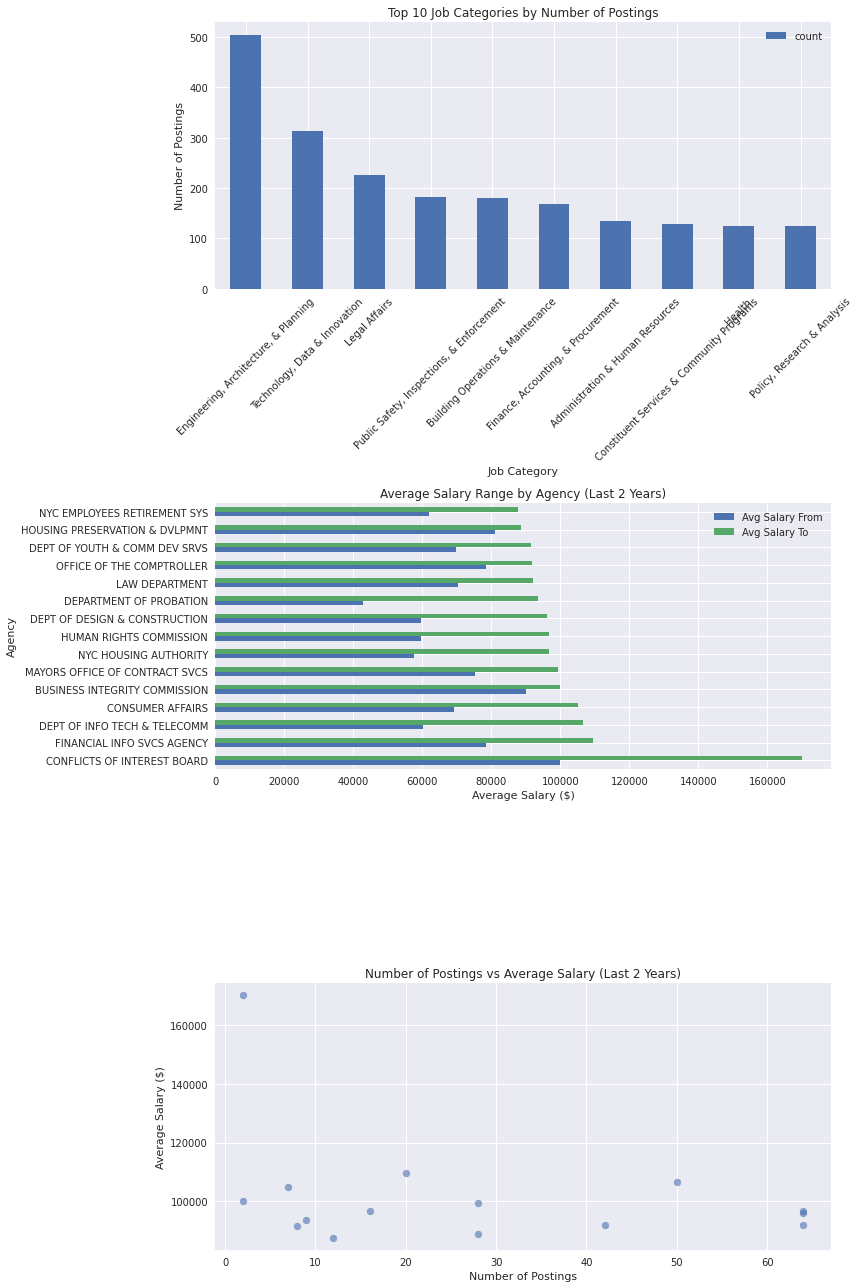

In [9]:
# Convert Spark DataFrames to Pandas for visualization
recent_salaries_pd = recent_salaries.toPandas()
category_counts_pd = category_counts.toPandas()

# Set up the visualization style
plt.style.use('seaborn')

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# 1. Top 10 Job Categories
category_counts_pd.plot(kind='bar', x='Job Category', y='count', ax=ax1)
ax1.set_title('Top 10 Job Categories by Number of Postings')
ax1.set_xlabel('Job Category')
ax1.set_ylabel('Number of Postings')
ax1.tick_params(axis='x', rotation=45)

# 2. Average Salary by Agency (Last 2 Years)
recent_salaries_pd = recent_salaries_pd.head(15)  # Top 15 agencies
recent_salaries_pd.plot(kind='barh', x='Agency', y=['Avg Salary From', 'Avg Salary To'], ax=ax2)
ax2.set_title('Average Salary Range by Agency (Last 2 Years)')
ax2.set_xlabel('Average Salary ($)')

# 3. Number of Postings vs Average Salary
ax3.scatter(recent_salaries_pd['Number of Postings'], 
           recent_salaries_pd['Avg Salary To'],
           alpha=0.6)
ax3.set_title('Number of Postings vs Average Salary (Last 2 Years)')
ax3.set_xlabel('Number of Postings')
ax3.set_ylabel('Average Salary ($)')
ax3.grid(True)



plt.tight_layout()
plt.show()